<a href="https://colab.research.google.com/github/matthewpecsok/data_engineering/blob/main/tutorials/de_object_storage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cloud object storage

This tutorial will teach you how to move files into object storage in GCP.

this tutorial requires you to have created a GCP project and a storage bucket created.

1.    Log into console.cloud.google.com
2.    Create a storage bucket
3.    Create an IAM service account with Storage Object User Role
4.    Add a KEY (JSON)
5.    Upload the key to you colab VM

In [15]:
from google.colab import userdata
import os
import sqlite3
import pandas as pd
from google.cloud import storage

In [16]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/de-object-assignment-fall2024-4024d1cea3fb.json"

# download the northwind sqlite db

In [2]:
!wget -O northwind.db https://github.com/matthewpecsok/data_engineering/raw/main/data/northwind.db

--2024-08-01 17:11:28--  https://github.com/matthewpecsok/data_engineering/raw/main/data/northwind.db
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matthewpecsok/data_engineering/main/data/northwind.db [following]
--2024-08-01 17:11:28--  https://raw.githubusercontent.com/matthewpecsok/data_engineering/main/data/northwind.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 602112 (588K) [application/octet-stream]
Saving to: ‘northwind.db’

northwind.db        100%[===================>] 588.00K  --.-KB/s    in 0.04s   

2024-08-01 17:11:28 (16.4 MB/s) - ‘northwind.db’ saved [602112/602112]



# create a connection object

In [3]:
conn = sqlite3.connect("northwind.db")

#  retrieve a list of table names from the database

using pandas and the connection object

In [4]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)

,name
0,Categories
1,sqlite_sequence
2,CustomerCustomerDemo
3,CustomerDemographics
4,Customers
5,Employees
6,EmployeeTerritories
7,Order Details
8,Orders
9,Products


# writing dataframes to a file



1.   read the customers table into a pandas dataframe
2.   write the dataframe to a csv file (exclude the index)
3.   using the shell command tail show the last 10 rows of the csv file.



## CSV

In [5]:
customers = pd.read_sql("SELECT * FROM customers", conn)
customers.to_csv("customers.csv",index=False)
!tail customers.csv

Val2 ,IT,Val2,IT,,,,,,,
VALON,IT,Valon Hoti,IT,,,,,,,
VICTE,Victuailles en stock,Mary Saveley,Sales Agent,"2, rue du Commerce",Lyon,Western Europe,69004,France,78.32.54.86,78.32.54.87
VINET,Vins et alcools Chevalier,Paul Henriot,Accounting Manager,59 rue de l'Abbaye,Reims,Western Europe,51100,France,26.47.15.10,26.47.15.11
WANDK,Die Wandernde Kuh,Rita Müller,Sales Representative,Adenauerallee 900,Stuttgart,Western Europe,70563,Germany,0711-020361,0711-035428
WARTH,Wartian Herkku,Pirkko Koskitalo,Accounting Manager,Torikatu 38,Oulu,Scandinavia,90110,Finland,981-443655,981-443655
WELLI,Wellington Importadora,Paula Parente,Sales Manager,"Rua do Mercado, 12",Resende,South America,08737-363,Brazil,(14) 555-8122,
WHITC,White Clover Markets,Karl Jablonski,Owner,305 - 14th Ave. S. Suite 3B,Seattle,North America,98128,USA,(206) 555-4112,(206) 555-4115
WILMK,Wilman Kala,Matti Karttunen,Owner/Marketing Assistant,Keskuskatu 45,Helsinki,Scandinavia,21240,Finland,90-224 8858,90-224 8858
WOLZA,Wolski

In [6]:
customers.shape

(93, 11)

In [7]:
!ls -ltrh customers.csv

-rw-r--r-- 1 root root 13K Aug  1 17:12 customers.csv


## Parquet

In [8]:
customers.to_parquet("customers.parquet",index=False)

In [9]:
!ls -ltrh customers*

-rw-r--r-- 1 root root 13K Aug  1 17:12 customers.csv
-rw-r--r-- 1 root root 18K Aug  1 17:12 customers.parquet


#  Parquet vs CSV

based on these results is it better to use csv or parquet for customer data?

1.   read the orders table into a pandas dataframe
2.   write the dataframe to a csv file (exclude the index)
3.   using the shell command tail show the last 10 rows of the csv file.


In [10]:
orders = pd.read_sql("SELECT * FROM orders", conn)
orders.to_csv("orders.csv",index=False)
!tail orders.csv

11068,QUEEN,8,2018-05-04,2018-06-01,,2,81.75,Queen Cozinha,"Alameda dos Canàrios, 891",Sao Paulo,South America,05487-020,Brazil
11069,TORTU,1,2018-05-04,2018-06-01,2018-05-06,2,15.67,Tortuga Restaurante,Avda. Azteca 123,México D.F.,Central America,5033,Mexico
11070,LEHMS,2,2018-05-05,2018-06-02,,1,136.0,Lehmanns Marktstand,Magazinweg 7,Frankfurt a.M.,Western Europe,60528,Germany
11071,LILAS,1,2018-05-05,2018-06-02,,1,0.93,LILA-Supermercado,Carrera 52 con Ave. Bolívar #65-98 Llano Largo,Barquisimeto,South America,3508,Venezuela
11072,ERNSH,4,2018-05-05,2018-06-02,,2,258.64,Ernst Handel,Kirchgasse 6,Graz,Western Europe,8010,Austria
11073,PERIC,2,2018-05-05,2018-06-02,,2,24.95,Pericles Comidas clásicas,Calle Dr. Jorge Cash 321,México D.F.,Central America,5033,Mexico
11074,SIMOB,7,2018-05-06,2018-06-03,,2,18.44,Simons bistro,Vinbæltet 34,Kobenhavn,Northern Europe,1734,Denmark
11075,RICSU,8,2018-05-06,2018-06-03,,2,6.19,Richter Supermarkt,Starenweg 5,Genève,Western Europe,1204,Switzerland
1

In [11]:
orders.shape

(830, 14)

1.   read the order detail table into a pandas dataframe
2.   write the dataframe to a csv file (exclude the index)
3.   using the shell command tail show the last 10 rows of the csv file.


In [13]:
order_detail = pd.read_sql("SELECT * FROM 'Order Details'", conn)
order_detail.to_csv("order_detail.csv",index=False)
!tail order_detail.csv

11077,41,9.65,3,0.0
11077,46,12.0,3,0.02
11077,52,7.0,2,0.0
11077,55,24.0,2,0.0
11077,60,34.0,2,0.06
11077,64,33.25,2,0.03
11077,66,17.0,1,0.0
11077,73,15.0,2,0.01
11077,75,7.75,4,0.0
11077,77,13.0,2,0.0


In [14]:
order_detail.shape

(2155, 5)

# Interacting with Cloud Object Storage

You'll create a project, storage bucket and move files from Colab to the storage account.

## create your GCP project

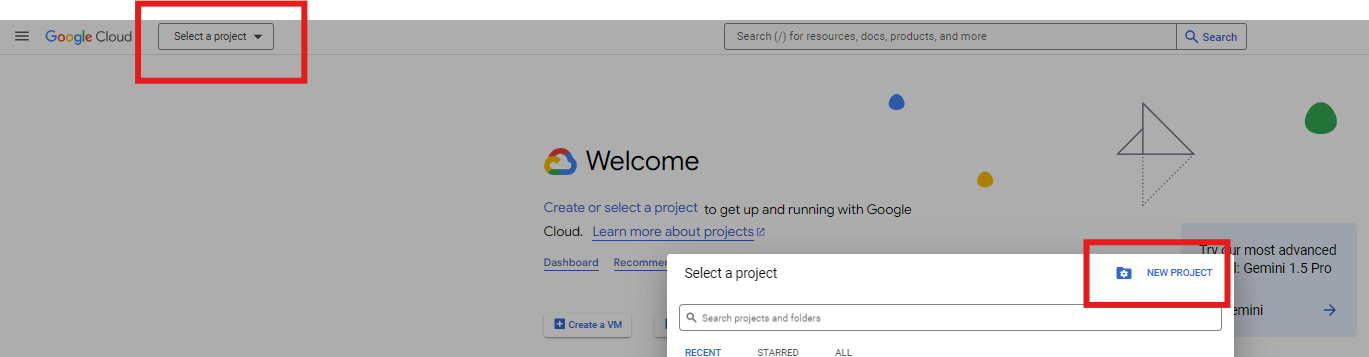

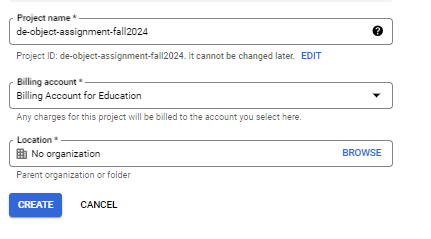

## select the newly created project

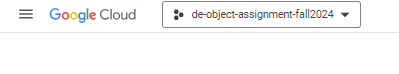

## Creating your first GCP storage bucket.



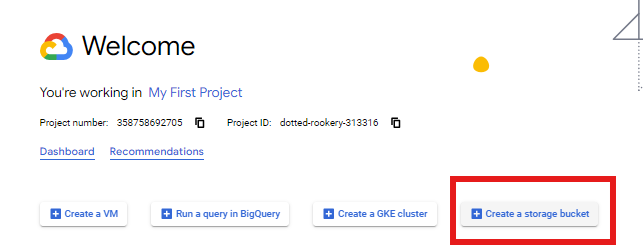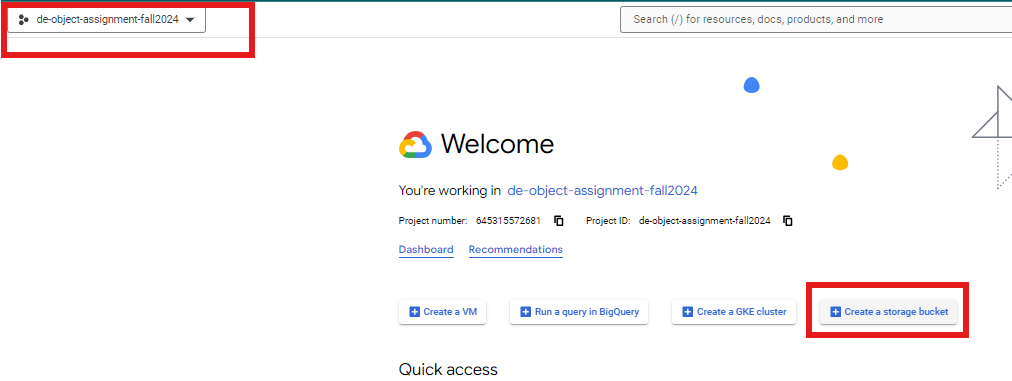

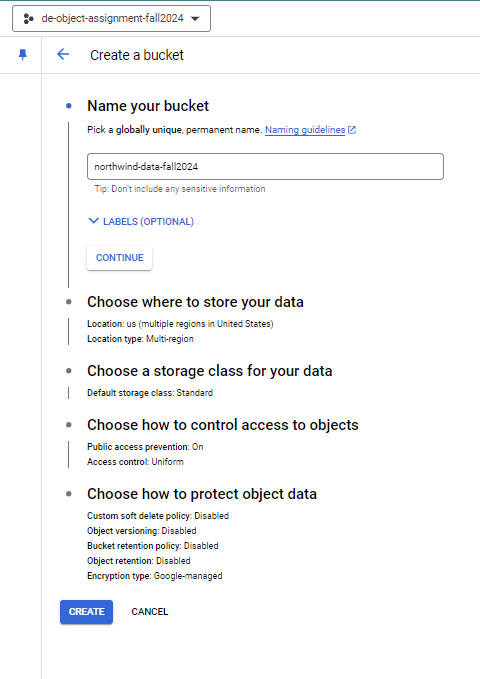

## Create Service Account

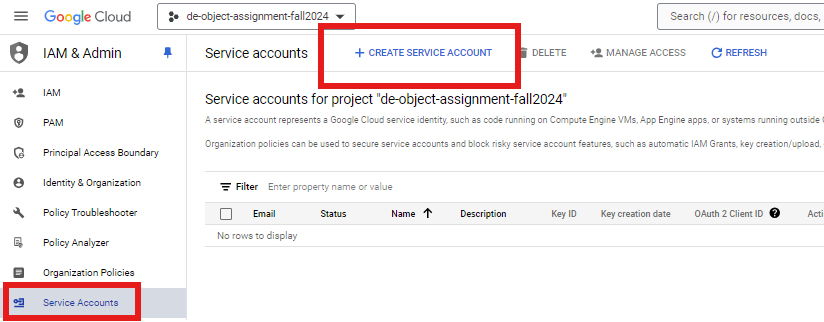

### give the service account a name



### give the service account: Storage Object Admin access.

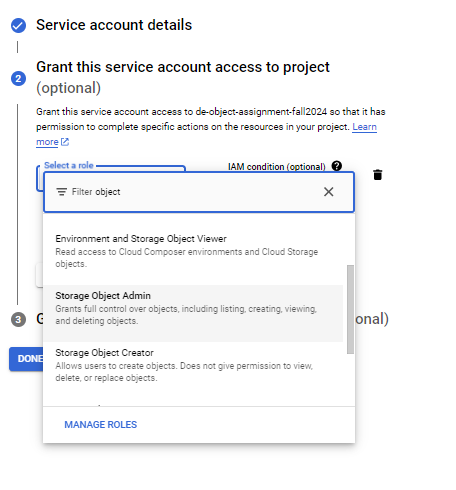

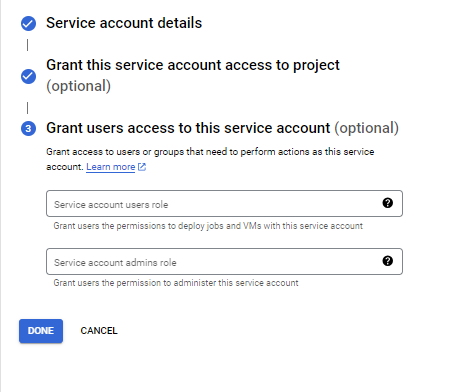

### create KEYS



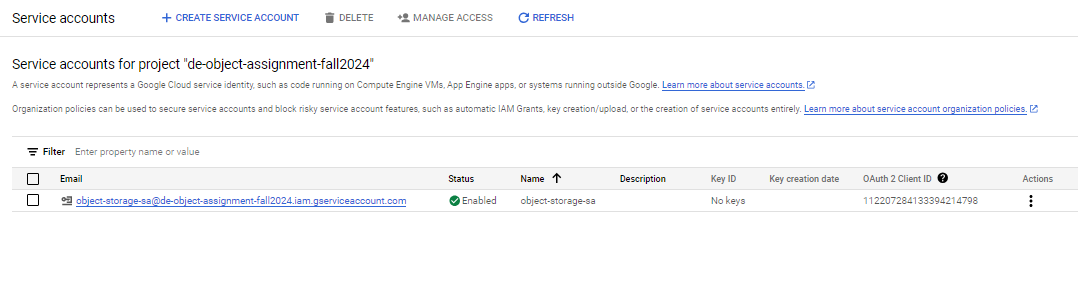

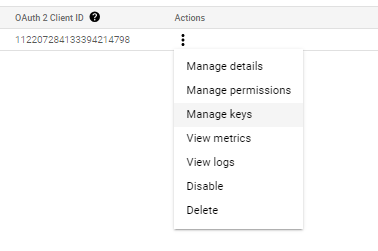

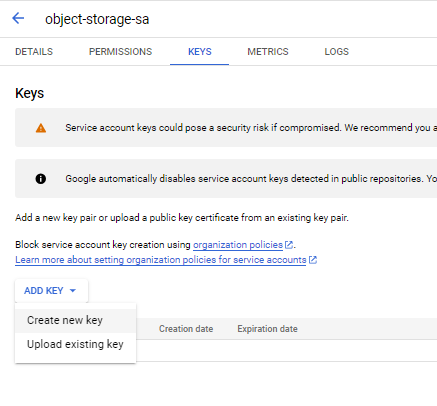

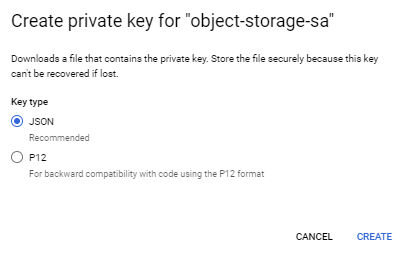

### save the JSON file locally

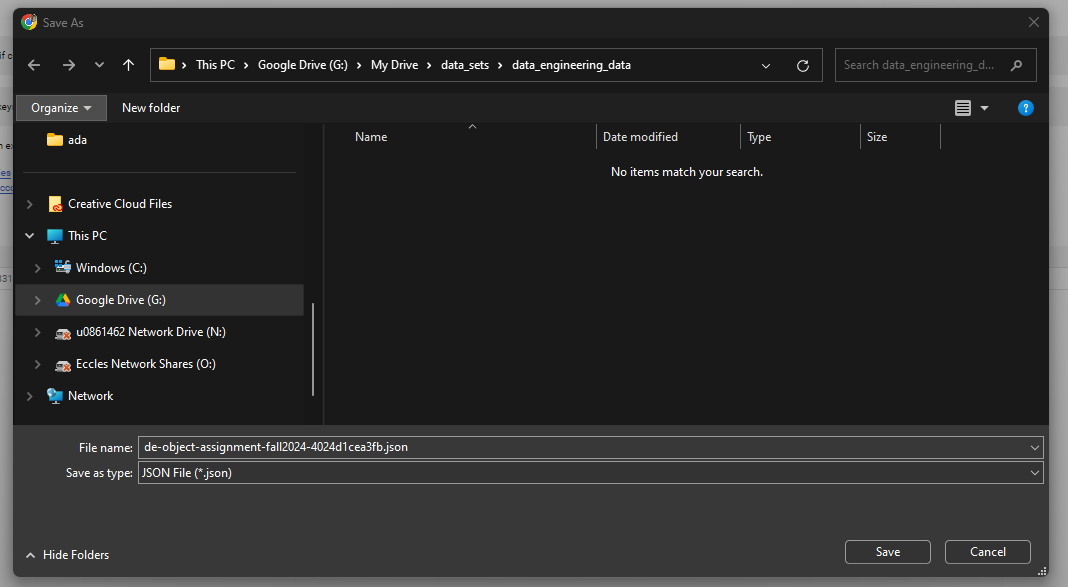

### Upload the JSON Key to Colab

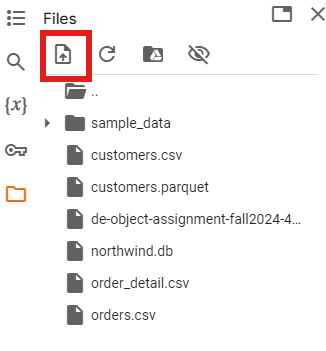

### Copy path to key

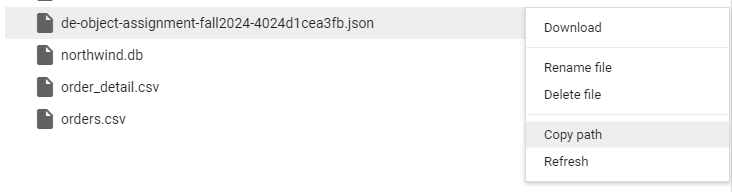

### update existing os environment variable



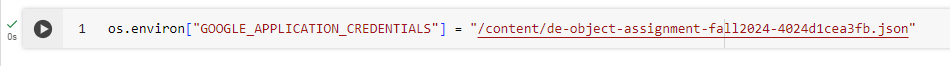

# Set project variable

In [17]:
GCP_PROJECT = 'de-object-assignment-fall2024'

# Set bucket name

In [18]:
STORAGE_BUCKET = 'northwind-data-fall2024'

# create the client object, choose the bucket for the client, upload the file.

In [19]:
storage_client = storage.Client() # create the Client.
bucket = storage_client.bucket(STORAGE_BUCKET) # get the bucket instance
blob = bucket.blob('customers.csv') # create a new blob, give it a name (can be different that the local filename)

blob.upload_from_filename('customers.csv') # upload the local file named 'customers.csv'

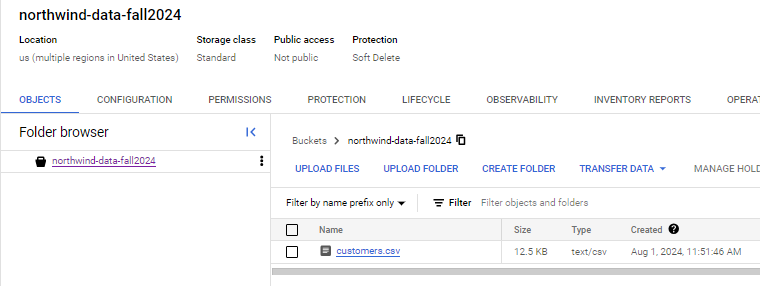

In [20]:
blob_to_download = bucket.blob('customers.csv') # create a new blob

blob.download_to_filename('customers_from_object_storage.csv') # upload the file

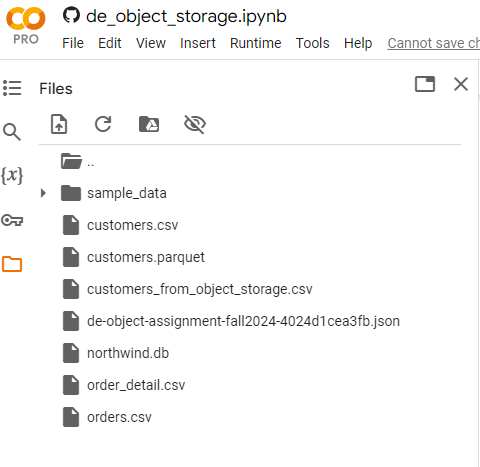